## Config

In [ ]:
import utils.configs as Config
config_path = "utils/configs.json"
config = Config.Config(config_path)


SHOULD_TRAIN = bool(config.get_pipeline_parameter()["training"])
SHOULD_PLOT = bool(config.get_pipeline_parameter()["plotting"])
BB_MODEL_NO = config.get_pipeline_parameter()["bb_model"]
HW_MODEL_NO = config.get_pipeline_parameter()["handwriting_model"]

importing the required packages and libraries.

In [ ]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from keras.callbacks import EarlyStopping

Globale Variable

In [ ]:
WORKSPACE_PATH = 'bounding_box/workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
ORIGINAL_ANNOTATION_PATH = ANNOTATION_PATH+'/original'
IMAGE_PATH = WORKSPACE_PATH+'/images'
ORIGINAL_IMAGE_PATH = IMAGE_PATH+'/original'
MODEL_PATH = WORKSPACE_PATH+'/models'
TEST_IMAGE_PATH = IMAGE_PATH +'/Bilder'
 
SPLIT_RATIO = 0.2
BATCH_SIZE = 2
LEARNING_RATE = 0.0001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
NEW_HEIGHT = 640
NEW_WIDTH = 640  

The Dataset Preparation

In [ ]:
class_ids = [
"Ausbildung",
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Ausbildung_Staette" ,
"Person" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung" ,
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]
sub_class_ids = [
"Ausbildung_Staette" ,
"Ausbildung_Klasse" ,
"Ausbildung_Antrag_gestellt_ja" ,
"Ausbildung_Antrag_gestellt_nein" ,
"Ausbildung_Amt" ,
"Ausbildung_Foerderungsnummer" ,
"Ausbilung_Abschluss" ,
"Ausbildung_Vollzeit" ,
"Ausbildung" ,
"Ausbildung_Teilzeit" ,
"Person_Geburtsort" ,
"Person_maennlich" ,
"Person_Geburtsdatum" ,
"Person_weiblich",
"Person_divers",
"Person_Name",
"Person_Familienstand" ,
"Person_Vorname" ,
"Person_Geburtsname" ,
"Person_Familienstand_seit",
"Person_Stattsangehörigkeit_eigene" ,
"Person_Stattsangehörigkeit_Ehegatte" ,
"Person_Kinder",
"Wohnsitz_Strasse",
"Wohnsitz_Land",
"Wohnsitz_Postleitzahl",
"Wohnsitz_Hausnummer",
"Wohnsitz_Adresszusatz",
"Wohnsitz_Ort",
"Wohnsitz_waehrend_Ausbildung_Strasse",
"Wohnsitz_waehrend_Ausbildung_Hausnummer",
"Wohnsitz_waehrend_Ausbildung_Land",
"Wohnsitz_waehrend_Ausbildung_Ort",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_nein",
"Wohnsitz_waehrend_Ausbildung_Adresszusatz",
"Wohnsitz_waehrend_Ausbildung_Postleitzahl",
"Wohnsitz_waehrend_Ausbildung_elternmiete",
"Wohnsitz_waehrend_Ausbildung_elternwohnung_ja",
"Wohnsitz_waehrend_Ausbildung_elternmiete_nein"
]
main_class_ids=[
    "Wohnsitz_waehrend_Ausbildung" ,
    "Ausbildung",
    "Person" ,
    "Wohnsitz",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
main_class_mapping = dict(zip(range(len(main_class_ids)), main_class_ids))
sub_class_mapping = dict(zip(range(len(sub_class_ids)), sub_class_ids))
print(class_mapping)
print(main_class_mapping)
print(sub_class_mapping)

In [ ]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(ORIGINAL_ANNOTATION_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_ANNOTATION_PATH)
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(ORIGINAL_IMAGE_PATH, file_name)
        for file_name in os.listdir(ORIGINAL_IMAGE_PATH)
        if file_name.endswith(".jpg")
    ]
)

parsing the XML annotation files

In [ ]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [ ]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
 
    image_name = root.find("filename").text
    image_path = os.path.join(ORIGINAL_IMAGE_PATH, image_name)
    
    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
 
        bbox = obj.find("bndbox")
        boxes.append( create_box(bbox))
        #main labels
        if (cls=='Wohnsitz_waehrend_Ausbildung')or(cls=='Ausbildung') or (cls =='Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append( create_box(bbox))
        else:
            bbox = obj.find("bndbox")
            sub_boxes.append( create_box(bbox))
            sub_classes.append(cls)
            print(cls)
    class_ids = map_class_id(classes, cls)
    main_class_ids = map_class_id(main_classes, cls)            
    sub_class_ids = map_class_id(sub_classes, cls)

    return image_path, boxes, class_ids, main_class_ids, sub_class_ids, main_boxes, sub_boxes, image_name
 

In [ ]:
image_paths = []
image_names = []
bbox = []
classes = []
main_classes = []
sub_classes= []
main_bbox= []
sub_bbox= []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids, main_class_ids,sub_class_ids, main_boxes, sub_boxes, image_name = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)
    image_names.append(image_name)

    main_classes.append(main_class_ids)
    sub_classes.append(sub_class_ids)
    main_bbox.append(main_boxes)
    sub_bbox.append(sub_boxes)

arr=np.array(sub_bbox)
print(arr.shape)
subset_image_paths_all=image_paths
subset_class_ids_all=sub_classes
subset_boxes_all=sub_bbox
print(subset_class_ids_all)

In [ ]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    
    
def scale_bounding_boxes(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)

    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    resized_boxes_for_one_image=[]
    #for box in bounding_boxes:
    resized_boxes = []
    x_min = (bounding_boxes[0]*width_ratio)
    y_min = (bounding_boxes[1]*height_ratio)
    x_max = (bounding_boxes[2]*width_ratio)
    y_max = (bounding_boxes[3]*height_ratio)
    #resized_boxes.append([x_min,y_min,x_max,y_max])
    #resized_boxes_for_one_image.append(resized_boxes)
    return [x_min,y_min,x_max,y_max]


In [ ]:
#Create Images from main_classes
IMAGES_MAIN_CLASSES_PATH = IMAGE_PATH +'/640x640_main_classes'

def create_main_images(input_path, output_path, box):
    startY, endY, startX, endX = int(np.round(box[1])), int(np.round(box[3])), int(np.round(box[0])), int(np.round(box[2]))
    image =  cv2.imread(input_path)
    cropped_image = image[startY:endY, startX:endX]
    cv2.imwrite(output_path, cropped_image)  

box_ratio_factors = []
sub_box_calculated = []
main_images_paths = []
main_image_names = []

def calculate_box_ratio_factor(image_path,box):
    image = cv2.imread(image_path)
    width = image.shape[0]
    height = image.shape[1]
    box[2], box[2], box[2], box[2]
    relative_xbl = box[0] #/ width
    relative_ybl = box[1] #/ height
    relative_xtr = box[2] #/ width
    relative_ytr = box[3] #/ height
    return [relative_xbl,relative_ybl,relative_xtr,relative_ytr]

def array_calculation(sub_box, main_box):
    return [sub_box[0]-main_box[0],sub_box[1]-main_box[1],sub_box[2]-main_box[0],sub_box[3]-main_box[1]]

#Bilder ausschneiden und speichern
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        box_ratio_factors.append(calculate_box_ratio_factor(image_paths[j], main_bbox[j][i]))
        create_main_images(image_paths[j],IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg', main_bbox[j][i])
        main_images_paths.append(IMAGES_MAIN_CLASSES_PATH+'/'+str(i)+'_'+str(j)+'.jpg')
        main_image_names.append(str(i)+'_'+str(j)+'.jpg')

#Resize Images auf 640x640
subsset_scaled_image_paths = []
for img in range(len(main_images_paths)):
    resize_imgaes(main_images_paths[img], IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img], 640, 640)
    subsset_scaled_image_paths.append(IMAGE_PATH+ '/640x640_main_classes_scaled/' +main_image_names[img])
#print(subsset_scaled_image_paths)

#Anpassen der Bounding Box Koordinaten zu dem jeweiligen Bildausschnitt
for i in range(len(main_class_ids)):
    for j in range(len(image_paths)):
        for k in range(len(sub_class_ids)):
            sub_box_calculated.append(array_calculation(sub_bbox[j][k], main_bbox[j][i]))



sub_boxes_main_class_1=[]  
sub_boxes_main_class_2=[] 
sub_boxes_main_class_3=[] 
sub_boxes_main_class_4=[] 
sub_boxes_all_main_classes=[]

scaled_sub_boxes_main_class_1=[]  
scaled_sub_boxes_main_class_2=[] 
scaled_sub_boxes_main_class_3=[] 
scaled_sub_boxes_main_class_4=[] 

#Boxen im Verhältnis der main_box zu 640x640 scalen
for i in range(len(image_names)): #18 Bilder
    for j in range(len(sub_class_ids)): #38 Klassen
        arr=[]
        if j < 10: #Ausbildung
            sub_boxes_main_class_1.append(array_calculation(sub_bbox[i][j], main_bbox[i][0]))
            scaled_sub_boxes_main_class_1.append(scale_bounding_boxes(main_images_paths[i],sub_boxes_main_class_1[i],640,640))

        elif (j >= 10) and (j <= 21) :#Person
            sub_boxes_main_class_2.append(array_calculation(sub_bbox[i][j], main_bbox[i][1]))
            scaled_sub_boxes_main_class_2.append(scale_bounding_boxes(main_images_paths[i+18],sub_boxes_main_class_2[i],640,640))
        elif (j >= 22) and (j <= 27) :#Wohnsitz
            #sub_boxes_main_class_3.append(sub_bbox[i][j])
            sub_boxes_main_class_3.append(array_calculation(sub_bbox[i][j], main_bbox[i][2]))
            scaled_sub_boxes_main_class_3.append(scale_bounding_boxes(main_images_paths[i+36],sub_boxes_main_class_3[i],640,640))
        elif (j >= 28) and (j <= 37) :#Wohnsitz_während_Ausildung
            sub_boxes_main_class_4.append(array_calculation(sub_bbox[i][j], main_bbox[i][3]))
            scaled_sub_boxes_main_class_4.append(scale_bounding_boxes(main_images_paths[i+54],sub_boxes_main_class_4[i],640,640))

In [ ]:
def show_image(image, boxes):
    image = cv2.imread(image)

    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 

    # Bounding Boxes zeichnen
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [ ]:
show_image(main_images_paths[0],sub_boxes_main_class_1)
show_image(main_images_paths[18],sub_boxes_main_class_2)
show_image(main_images_paths[36],sub_boxes_main_class_3)
show_image(main_images_paths[54],sub_boxes_main_class_4)

show_image(subsset_scaled_image_paths[0],scaled_sub_boxes_main_class_1)
show_image(subsset_scaled_image_paths[18],scaled_sub_boxes_main_class_2)
show_image(subsset_scaled_image_paths[36],scaled_sub_boxes_main_class_3)
show_image(subsset_scaled_image_paths[54],scaled_sub_boxes_main_class_4)

In [ ]:
#create 4 datasets
#image_paths
#shape(18,x)
subset_images_paths_1 = []
subset_images_paths_2 = []
subset_images_paths_3 = []
subset_images_paths_4 = []
for i in range(len(subsset_scaled_image_paths)):
        if i < 18: #Ausbildung
            subset_images_paths_1.append(subsset_scaled_image_paths[i])
        elif (i >= 18) and (i <= 35) :#Person
            subset_images_paths_2.append(subsset_scaled_image_paths[i])
        elif (i >= 36) and (i <= 53) :#Wohnsitz
            subset_images_paths_3.append(subsset_scaled_image_paths[i])
        elif (i >= 54) and (i <= 73) :#Wohnsitz_während_Ausildung
            subset_images_paths_4.append(subsset_scaled_image_paths[i])
#classes
subset_class_ids_1_1 = []
subset_class_ids_2_2 = []
subset_class_ids_3_3 = []
subset_class_ids_4_4 = []
subset_class_ids_1 = []
subset_class_ids_2 = []
subset_class_ids_3 = []
subset_class_ids_4 = []
classes=[]
#shape(18,x)
for i in range(len(subset_class_ids_all[0])):
        if i < 10: #Ausbildung
                subset_class_ids_1_1.append(subset_class_ids_all[0][i])
        elif (i >= 10) and (i <= 21) :#Person
                subset_class_ids_2_2.append(subset_class_ids_all[0][i])
        elif (i >= 22) and (i <= 27) :#Wohnsitz
                subset_class_ids_3_3.append(subset_class_ids_all[0][i])
        elif (i >= 28) and (i <= 37) :#Wohnsitz_während_Ausildung
                subset_class_ids_4_4.append(subset_class_ids_all[0][i])

for i in range (0,18):
    subset_class_ids_1.append(subset_class_ids_1_1)
    subset_class_ids_2.append(subset_class_ids_2_2)
    subset_class_ids_3.append(subset_class_ids_3_3)
    subset_class_ids_4.append(subset_class_ids_4_4)

#boxen
subset_boxes_1 = []
subset_boxes_2 = []
subset_boxes_3 = []
subset_boxes_4 = []
#shape(18,x,4)


arr= np.array(scaled_sub_boxes_main_class_1)
arr_1=arr.reshape(18,10,4)
for j in range(0,18):
    arr_1_1=[]
    for i in range(0,10):
        arr_1_1.append(arr_1[i][0])
    subset_boxes_1.append(arr_1_1)

arr= np.array(scaled_sub_boxes_main_class_2)
arr_2=arr.reshape(18,12,4)
for j in range(0,18):
    arr_1_1=[]
    for i in range(0,12):
        arr_1_1.append(arr_2[i][0])
    subset_boxes_2.append(arr_1_1)

arr= np.array(scaled_sub_boxes_main_class_3)
arr_3=arr.reshape(18,6,4)
for j in range(0,18):
    arr_1_1=[]
    for i in range(0,6):
        arr_1_1.append(arr_3[i][0])
    subset_boxes_3.append(arr_1_1)

arr= np.array(scaled_sub_boxes_main_class_4)
arr_4=arr.reshape(18,10,4)
for j in range(0,18):
    arr_1_1=[]
    for i in range(0,10):
        arr_1_1.append(arr_4[i][0])
    subset_boxes_4.append(arr_1_1)

print(subset_class_ids_1)
arr=np.array(subset_class_ids_4)
print(arr.shape)
arrs=np.array(subset_class_ids_1)
print(arrs.shape)
arrf=np.array(subset_boxes_1)
print(arrf.shape)

In [ ]:
#conc_paths = np.concatenate((subset_images_paths_1, subset_images_paths_2, subset_images_paths_3, subset_images_paths_4), axis=0)
#print(conc_paths.shape)
#conc_boxes = np.concatenate((subset_boxes_1, subset_boxes_2, subset_boxes_3, subset_boxes_4), axis=1)
#print(conc_boxes.shape)
#conc_classes = np.concatenate(( subset_class_ids_1, subset_class_ids_2, subset_class_ids_3, subset_class_ids_4), axis=1)
#print(conc_classes.shape)

classes=[]
images=[]
box=[]
#shape (72,) subset aus 4 main_boxen
for i in range(len(subset_boxes_1)):
    box.append(subset_boxes_1[i])
    images.append(subset_images_paths_1[i])
    classes.append(subset_class_ids_1[i])
for i in range(len(subset_boxes_2)):
    box.append(subset_boxes_2[i])
    images.append(subset_images_paths_2[i])
    classes.append(subset_class_ids_2[i])
for i in range(len(subset_boxes_3)):
    box.append(subset_boxes_3[i])
    images.append(subset_images_paths_3[i])
    classes.append(subset_class_ids_3[i])
for i in range(len(subset_boxes_4)):
    box.append(subset_boxes_4[i])
    images.append(subset_images_paths_4[i])
    classes.append(subset_class_ids_4[i])

#hinzugügen des sets der ganzen Seite
for i in range(len(subset_boxes_all)):
    box.append(subset_boxes_all[i])
    images.append(subset_image_paths_all[i])
    classes.append(subset_class_ids_all[i])

arr=np.array(subset_boxes_1)
print(arr.shape)
print(len(classes))
print(classes[0])

In [ ]:
def create_data_tensor(image_paths,classes,bbox):
    bbox = tf.ragged.constant(bbox, dtype=tf.float32)
    classes = tf.ragged.constant(classes, dtype=tf.int64)
    image_paths = tf.ragged.constant(image_paths, dtype=tf.string)
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    return data

In [ ]:
#merged_sub_data = create_data_tensor(merged_paths, merged_classes, merged_boxes)

new_sub_data_all = create_data_tensor(images,classes, box )

#new_sub_data_all = create_data_tensor(subset_image_paths_all, subset_class_ids_all, subset_boxes_all)

new_sub_data_1 = create_data_tensor(subset_images_paths_1, subset_class_ids_1, subset_boxes_1)
new_sub_data_2 = create_data_tensor(subset_images_paths_2, subset_class_ids_2, subset_boxes_2)
new_sub_data_3 = create_data_tensor(subset_images_paths_3, subset_class_ids_3, subset_boxes_3)
new_sub_data_4 = create_data_tensor(subset_images_paths_4, subset_class_ids_4, subset_boxes_4)


In [ ]:
def create_train_test_data(split, data_tensor):
    num_val = int(split * SPLIT_RATIO)#int(len(image_path_list)
    val_data = data_tensor.take(num_val)
    train_data = data_tensor.skip(num_val)
    return val_data, train_data

In [ ]:
#Bilder durchmischen
new_sub_data_all = new_sub_data_all.shuffle(90, reshuffle_each_iteration=True)

In [ ]:
#sub_val_data_all,sub_train_data_all  = create_train_test_data(18 , zipped_ds)


sub_val_data_all, sub_train_data_all  = create_train_test_data(90 , new_sub_data_all)

sub_val_data_1, sub_train_data_1  = create_train_test_data(18 , new_sub_data_1)
sub_val_data_2, sub_train_data_2  = create_train_test_data(18 , new_sub_data_2)
sub_val_data_3, sub_train_data_3  = create_train_test_data(18 , new_sub_data_3)
sub_val_data_4, sub_train_data_4  = create_train_test_data(18 , new_sub_data_4)


In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image
 

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
augmenter = keras.Sequential(
    layers=[
        #keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        #keras_cv.layers.RandomRotation(factor=0.2, bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1, 1),
            bounding_box_format="xyxy",
        ),
    ]
)

In [ ]:
def create_train_ds(train_data):
    train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(BATCH_SIZE * 8)
    train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    return train_ds

In [ ]:
print(len(sub_train_data_all))

In [ ]:
sub_train_ds_all = create_train_ds(sub_train_data_all)

sub_train_ds_1 = create_train_ds(sub_train_data_1)
sub_train_ds_2 = create_train_ds(sub_train_data_2)
sub_train_ds_3 = create_train_ds(sub_train_data_3)
sub_train_ds_4 = create_train_ds(sub_train_data_4)

#sub_trains_ds_zipped = tf.data.Dataset.zip(sub_train_ds_all, sub_train_ds_1, sub_train_ds_2, sub_train_ds_3, sub_train_ds_4)

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1, 1),
    bounding_box_format="xyxy",
)

def create_val_ds(val_data):
    val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(BATCH_SIZE * 8)
    val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
    val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
    return val_ds

In [ ]:
sub_val_ds_all= create_train_ds(sub_val_data_all)

sub_val_ds_1 = create_train_ds(sub_val_data_1)
sub_val_ds_2 = create_train_ds(sub_val_data_2)
sub_val_ds_3 = create_train_ds(sub_val_data_3)
sub_val_ds_4 = create_train_ds(sub_val_data_4)

#sub_val_ds_zipped = tf.data.Dataset.zip(sub_val_ds_all, sub_val_ds_1, sub_val_ds_2, sub_val_ds_3, sub_val_ds_4)

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.2,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [ ]:
visualize_dataset(sub_train_ds_all, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=2)
visualize_dataset(sub_val_ds_all, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

def create_train_val_tuple(train_ds,val_ds):
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds


In [ ]:
sub_train_ds_all,sub_val_ds_all=create_train_val_tuple(sub_train_ds_all,sub_val_ds_all)
sub_train_ds_1,sub_val_ds_1=create_train_val_tuple(sub_train_ds_1,sub_val_ds_1)
sub_train_ds_2,sub_val_ds_2=create_train_val_tuple(sub_train_ds_2,sub_val_ds_2)
sub_train_ds_3,sub_val_ds_3=create_train_val_tuple(sub_train_ds_3,sub_val_ds_3)
sub_train_ds_4,sub_val_ds_4=create_train_val_tuple(sub_train_ds_4,sub_val_ds_4)

define backbone

In [ ]:
def define_backbone(backbone):
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_xs_backbone_coco",
         load_weights=True 
    )
    return backbone

define optimizer

In [ ]:
def define_optimizer():
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        global_clipnorm=GLOBAL_CLIPNORM, #This ensures that gradients, which influence the model’s parameter updates, 
                                        # don’t become exceedingly large and destabilize training.
    )
    return optimizer

define YOLO8Detector

In [ ]:
def define_model(num_classes):
    model = keras_cv.models.YOLOV8Detector(
    num_classes=num_classes, #the number of object classes
    bounding_box_format="xyxy",
    backbone=define_backbone("yolo_v8_xs_backbone_coco"),
    fpn_depth=1,
)
    return model

compile model

In [ ]:
def compile_model(model):
    model.compile(
    optimizer=define_optimizer(), 
    classification_loss="binary_crossentropy", #calculates the discrepancy between anticipated class probabilities and actual class probabilities
    box_loss="ciou" # box_loss -> measure the difference between the predicted bounding boxes and the ground truth
                    # he Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding 
                    # boxes but also considers the difference in aspect ratio, center distance, and box size
)

fit model

In [ ]:
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

def fit_model(model, train_data, validation_data):
    history = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=EPOCH,
        callbacks=early_stopping,
        #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "workspace/models/yolo_coco_model.h5")],
    )
    return history

define NonMaxSuppression

In [ ]:
def define_NonMaxSuppression(model):
    model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format="xyxy",
        from_logits=True,
        iou_threshold=0.9,
        confidence_threshold=0.5
    
    )

define a base model, compile the base model and then loads the weights from a path

In [ ]:
def load_weight_model(model_path):
    base_model = define_model(len(class_mapping))
    compile_model(base_model)
    loaded_model = base_model.load_weights(model_path)
    return  loaded_model
    

save weights of a model

In [ ]:
def save_weights(model, name):
    save_model_path = MODEL_PATH + name
    model.save_weights(save_model_path)

define visualization methode

In [ ]:
def visualize_detections(model, dataset, bounding_box_format, class_mapping):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=5,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.4,
        class_mapping= class_mapping ,#class_mapping,
    )

define and compile model for sub_bbox

In [ ]:
yolo_coco_sub = define_model(43)
compile_model(yolo_coco_sub)

define and compile model for main_bbox

In [ ]:
yolo_coco_main = define_model(len(main_class_mapping))
compile_model(yolo_coco_main)

In [ ]:
MAIN_MODEL_PATH = MODEL_PATH+'/main_bbox_detector_model.h5'

#yolo_coco_main.load_weights(MAIN_MODEL_PATH)

fit main_bbox_model

In [ ]:
#main_bbox_history = fit_model(yolo_coco_main, main_train_ds, main_val_ds )

fit sub_bbox_model

In [ ]:
#yolo_coco_sub.fit(sub_trains_ds_zipped, epochs=5, validation_data=sub_val_ds_zipped)

sub_bbox_history_all= fit_model(yolo_coco_sub,sub_train_ds_all,sub_val_ds_all )

NEWSUB_5_SETS_MODEL_PATH = MODEL_PATH+'/new_sub_bbox_detector_model_5_datasets.h5'
#yolo_coco_sub.save_weights(NEWSUB_5_SETS_MODEL_PATH)
#yolo_coco_sub.load_weights(NEWSUB_5_SETS_MODEL_PATH)
#sub_bbox_history_1 = fit_model(yolo_coco_sub, sub_train_ds_1, sub_val_ds_1 )
"""
yolo_coco_sub.save_weights(NEWSUB_5_SETS_MODEL_PATH)
yolo_coco_sub.load_weights(NEWSUB_5_SETS_MODEL_PATH)
sub_bbox_history_2 = fit_model(yolo_coco_sub, sub_train_ds_2, sub_val_ds_2 )
yolo_coco_sub.save_weights(NEWSUB_5_SETS_MODEL_PATH)
yolo_coco_sub.load_weights(NEWSUB_5_SETS_MODEL_PATH)
sub_bbox_history_3 = fit_model(yolo_coco_sub, sub_train_ds_3, sub_val_ds_3 )
yolo_coco_sub.save_weights(NEWSUB_5_SETS_MODEL_PATH)
yolo_coco_sub.load_weights(NEWSUB_5_SETS_MODEL_PATH)
sub_bbox_history_4 = fit_model(yolo_coco_sub, sub_train_ds_4, sub_val_ds_4 )
"""


Plots

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    # Box Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['box_loss'], label='Training Box Loss')
    plt.plot(history.history['val_box_loss'], label='Validation Box Loss')
    plt.title('Training and Validation Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Loss')
    plt.legend()

    # Klassen Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_loss'], label='Training Class Loss')
    plt.plot(history.history['val_class_loss'], label='Validation Class Loss')
    plt.title('Training and Validation Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Class Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_metrics(sub_bbox_history_all)

visualization main bbox

In [ ]:
#visualize_detections(yolo_coco_main, dataset=main_val_ds, bounding_box_format="xyxy", class_mapping= main_class_mapping)

visualization sub bbox

In [ ]:
visualize_detections(yolo_coco_sub, dataset=sub_val_ds_all, bounding_box_format="xyxy", class_mapping= class_mapping)

save weights

In [ ]:
MAIN_MODEL_PATH = MODEL_PATH+'/main_bbox_detector_model.h5'

#yolo_coco_main.save_weights(MAIN_MODEL_PATH)

load model for sub_bbox and visualize

In [ ]:
#yolo_coco_sub.load_weights(MAIN_MODEL_PATH)

visualize a prediction with loaded_sub_model

In [ ]:
def predict_on_image(image_path, model):
    image =  cv2.imread(image_path)
    resized_image = cv2.resize(image, (640, 640))
    resized_image = np.expand_dims(resized_image, axis=0)  

    #predict
    predictions = model.predict(resized_image)
    boxes = predictions['boxes']
    confidence = predictions['confidence']
    classes = predictions['classes']
    iou_threshold = 0.5


    

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, conf, cls in zip(boxes[0], confidence[0], classes[0]):
        if conf > 0.1:
            xmin, ymin, xmax, ymax = box
            #label = f"Class {cls} ({conf:.2f})"
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')#, label=label)
            ax.add_patch(rect)

    plt.legend()
    plt.show()

In [ ]:
def predict_on_image(image_path, model):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (640, 640))
    resized_image = np.expand_dims(resized_image, axis=0)  

    # Predict
    predictions = model.predict(resized_image)
    boxes = predictions['boxes']
    confidence = predictions['confidence']
    classes = predictions['classes']

    sorted_indices = np.argsort(-confidence[0])  
    boxes = boxes[0][sorted_indices]
    confidence = confidence[0][sorted_indices]
    classes = classes[0][sorted_indices]

    unique_classes = np.unique(classes)
    selected_indices = []

    for cls in unique_classes:
        cls_indices = np.where(classes == cls)[0]
        if len(cls_indices) > 0:
            best_idx = cls_indices[0]  
            selected_indices.append(best_idx)

    selected_boxes = boxes[selected_indices]
    selected_confidence = confidence[selected_indices]
    selected_classes = classes[selected_indices]

    iou_threshold = 0.5

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box, conf, cls in zip(selected_boxes, selected_confidence, selected_classes):
        if conf > 0.1:
            xmin, ymin, xmax, ymax = box
            label = f"Class {cls} ({conf:.2f})"
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none' ,label=label)
            ax.add_patch(rect)

    plt.legend()
    plt.show()

In [ ]:

#lade bild
image_path1 = (IMAGE_PATH+ '/640x640_main_classes_scaled/0_4.jpg') 
image_path2 = (ORIGINAL_IMAGE_PATH+'/image_0004.jpg') 
predict_on_image(image_path1, yolo_coco_sub)
predict_on_image(image_path2, yolo_coco_sub)


In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

# Fake Prediction

In [ ]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
# import keras_cv

from tqdm.auto import tqdm
from tensorflow import keras
#from keras_cv import bounding_box
#from keras_cv import visualization
from keras.models import load_model
import numpy as np
from keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from keras.callbacks import EarlyStopping
import re

In [ ]:
he = 0
print(bool(he))

In [ ]:
# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join("data_zettel/Annotations", file_name)
        for file_name in os.listdir("data_zettel/Annotations")
        if file_name.endswith(".xml")
    ]
)
 
# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join("data_zettel/Annotations", file_name)
        for file_name in os.listdir("data_zettel/Annotations")
        if file_name.endswith(".jpg")
    ]
)

In [ ]:
def map_class_id(classes, cls):    
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return class_ids

def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    return [xmin, ymin, xmax, ymax]

In [ ]:
def parse_annotation_fake(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = f'data_zettel/filled_resized/{image_name}'

    boxes = []
    classes = []
    main_classes = []
    sub_classes = []
    main_boxes = []
    sub_boxes = []
    values = []
    
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)
        
        bbox = obj.find("bndbox")
        boxes.append(create_box(bbox))
        
        # main labels
        if (cls == 'Wohnsitz_waehrend_Ausbildung') or (cls == 'Ausbildung') or (cls == 'Person') or (cls == 'Wohnsitz'):
            main_classes.append(cls)
            bbox = obj.find("bndbox")
            main_boxes.append(create_box(bbox))
        else:
            attributes = obj.findall("attributes/attribute")
            for attribute in attributes:
                value_element = attribute.find("value")
                if value_element is not None:
                    value = value_element.text
                    if value is None:
                        value = ""
                    elif value is None or value.lower() in ["true", "false"]:
                        # Wenn der Wert None oder "True"/"False" ist, überspringe diese Iteration
                        continue
                    
                    # Versuche, den Wert in einen Float zu konvertieren
                    try:
                        float_value = float(value)
                        int_value = int(float_value)
                        values.append(str(int_value))  # Hier wird der Integer in einen String umgewandelt
                    except ValueError:
                        # Wenn die Konvertierung fehlschlägt, füge den originalen Wert zur Liste hinzu
                        values.append(value)
                    break
            
            bbox = obj.find("bndbox")
            sub_boxes.append(create_box(bbox))
            sub_classes.append(cls)
    return image_path, sub_boxes, values

In [ ]:
from collections import namedtuple
ImageInfo = namedtuple('ImageInfo', ['path', 'boxes', 'values'])

image_list = []
for xml_file in tqdm(xml_files): 
    image_path, sub_boxes, values= parse_annotation_fake(xml_file)
    image = ImageInfo(path=image_path, boxes=sub_boxes, values=values)
    numbers_to_check = ["31", "32", "33", "35", "36"]
    # Check if the string does not contain any of the specified numbers
    does_not_contain_numbers = all(number not in image.path for number in numbers_to_check)
    
    if does_not_contain_numbers:
        
            image_list.append(image)
            print(image.path)
        

### Crop ROI

In [ ]:
print(len(image_list[5].boxes))

In [ ]:
# Crop ROI
save_path_crops = "data_zettel/cropped_images"

import cv2
def crop(xmin, ymin, xmax, ymax, image_path):
    image = cv2.imread(image_path)
    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    imgCropped = image[ymin:ymax, xmin:xmax]
    return imgCropped


for index, image in enumerate(image_list):
    boxes = image.boxes
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = np.array(box)
        imgCropped = crop(xmin, ymin, xmax, ymax, image.path)
        if image.values[i] != "1" and image.values[i] != "0" and image.values[i] != "355" and image.values[i] != "356" and image.values[i] != "b"and image.values[i] != '' and image.values[i] != 'X':
            cv2.imwrite(f"{save_path_crops}/{index}_{i}.jpg", imgCropped)
            with open(f"{save_path_crops}/{index}_{i}.txt", 'w') as file:
                image.values[i] = image.values[i].replace(" ", "|")
                print(image.values[i])
                file.write(image.values[i])

# Handwriting

In [1]:
# Unsere Klassen
#import handwriting.load_data as load_data
import handwriting.load_transfer_data as load_transfer_data
import handwriting.testing_models as testing_models # Use: build_model9v3(img_width, img_height, char) 
import utils.configs as cfg
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import random
import time
import os

0_0
0_1
0_10
0_11
0_12
0_13
0_14
0_2
0_20
0_23
0_24
0_25
0_26
0_27
0_28
0_3
0_5
0_6
0_7
0_8
0_9
10_0
10_10
10_11
10_13
10_15
10_17
10_18
10_19
10_2
10_21
10_23
10_27
10_6
10_7
10_8
11_0
11_1
11_13
11_15
11_19
11_2
11_20
11_22
11_23
11_25
11_26
11_27
11_28
11_3
11_4
12_0
12_1
12_10
12_11
12_12
12_13
12_14
12_15
12_16
12_2
12_3
12_4
12_6
13_13
13_15
13_16
13_20
13_21
13_22
13_23
13_24
13_25
13_26
13_27
13_28
13_4
13_8
13_9
14_1
14_18
14_19
14_2
14_20
14_21
14_22
14_23
14_24
14_25
14_26
14_27
14_3
14_6
14_7
14_8
15_10
15_19
15_2
15_20
15_24
15_25
15_26
15_27
15_28
15_3
15_4
15_5
15_7
15_8
15_9
16_0
16_1
16_12
16_15
16_16
16_2
16_24
16_25
16_27
16_3
16_4
16_5
16_6
16_7
17_0
17_17
17_18
17_19
17_20
17_21
17_22
17_23
17_24
17_25
17_27
17_28
17_5
17_6
17_9
18_0
18_1
18_13
18_17
18_2
18_22
18_23
18_25
18_26
18_27
18_28
18_3
18_4
18_5
18_6
18_8
19_0
19_11
19_13
19_14
19_17
19_2
19_22
19_23
19_24
19_25
19_26
19_27
19_28
19_7
19_9
1_0
1_11
1_12
1_13
1_14
1_15
1_16
1_17
1_18
1_21
1_22
1_23
1_24
1_

## Config

In [2]:
config_path = "utils\configs.json"

config = cfg.Config(config_path)

# Pipeline
TRANSFER = bool(config.get_pipeline_parameter()["transfer"])

# Model Parameter
MODEL_SAVE = bool(config.get_model_parameter()["save"])
MODEL_NAME = config.get_model_parameter()["name"]
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

# Directory Parameter
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["model_dir"])
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath(config.get_directory_parameter()["test_dir"])
DATA_BASE_PATH = config.get_directory_parameter()["data_base_path"]

# Training Parameter
SAVE_HISTORY = bool(config.get_training_parameter()["save_history"])
EPOCHS = config.get_training_parameter()["epochs"]
BATCH_SIZE = config.get_training_parameter()["batch_size"] # default: 32 - 48
TF_SEED = config.get_training_parameter()["tf_seed"] # default: 42
LEARNING_RATE = config.get_training_parameter()["learning_rate"]
PATIENCE = config.get_training_parameter()["patience"] # default: 3

In [3]:
print(MODEL_SAVE)

True


## Load Data

In [4]:
# Default: seed = 42
# np.random.seed(TF_SEED)
# tf.random.set_seed(TF_SEED)

# Random
#seed = random.randint(1, 1000)
#np.random.seed(seed)
#tf.random.set_seed(seed)
print(LEARNING_RATE)
print(TF_SEED)

0.001
42


In [5]:
#load_data.print_samples(DATA_BASE_PATH)
if False: # IAM Dataset
    x_train_img_paths, y_train_labels = load_data.get_train_data()
    x_val_img_paths, y_val_labels = load_data.get_validation_data()
    #x_test_img_paths, y_test_labels = load_data.get_test_data()
else:
    x_train_img_paths, y_train_labels = load_transfer_data.get_train_data()
    x_val_img_paths, y_val_labels = load_transfer_data.get_validation_data()

In [6]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
#print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['data_zettel/cropped_images/74_4.jpg', 'data_zettel/cropped_images/27_19.jpg'] ['111991', 'DE']
Validation path: ['data_zettel/cropped_images/42_7.jpg', 'data_zettel/cropped_images/35_27.jpg'] ['New|Mexiko', 'Hacker|Way']


## Create Dataset

In [7]:
# Has to be here because load data functions need to be called before
import handwriting.tokenizer as tokenizer
import handwriting.custom_image_generator as cgi

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)

#train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT)

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
#aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)

## Show Examples

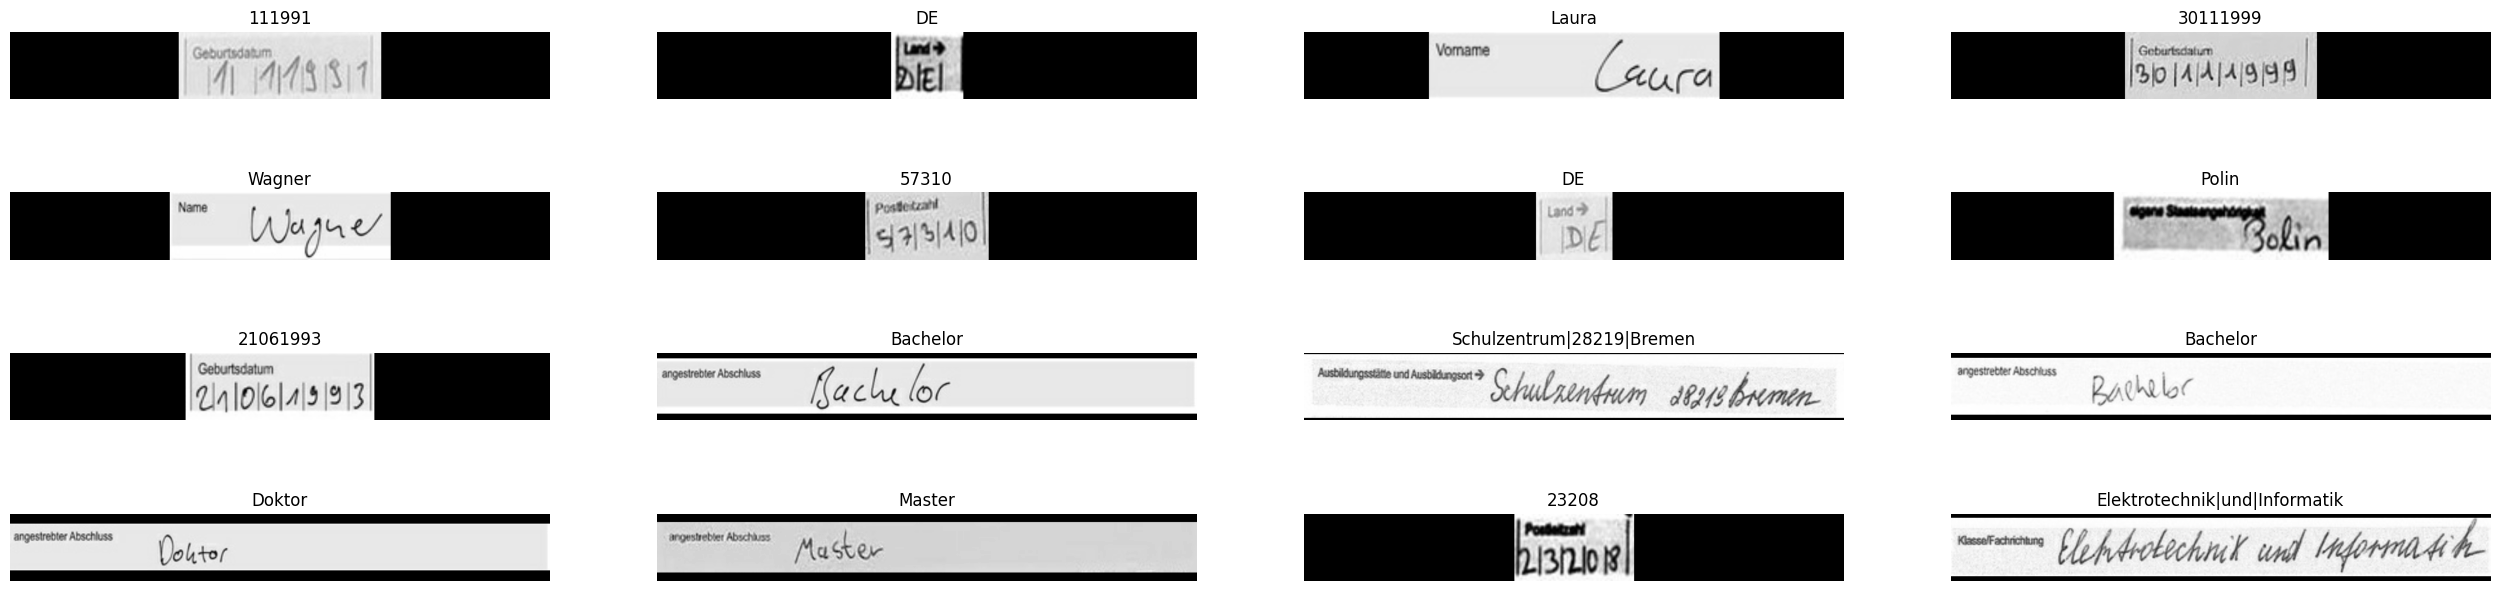

In [8]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [9]:
print(load_transfer_data.max_len)
print(load_transfer_data.characters)

47
[',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


# Data Augmentation

In [10]:
# # To see the augmentations from CustomImageGenerator
# train_generator = cgi.CustomImageGenerator(x_train_img_paths, y_train_labels, tokenizer.batch_size, IMAGE_WIDTH, IMAGE_HEIGHT)
# 
# example_batch = train_generator[0]
# augmented_images = example_batch[0]['image']
# 
# num_to_plot = 4
# fig, axes = plt.subplots(1, num_to_plot, figsize=(10, 10))
# 
# for i, ax in enumerate(axes.flatten()):
#     ax.imshow(np.squeeze(augmented_images[i]), cmap='gray')
#     ax.axis('off')
# 
# plt.tight_layout()
# plt.show()

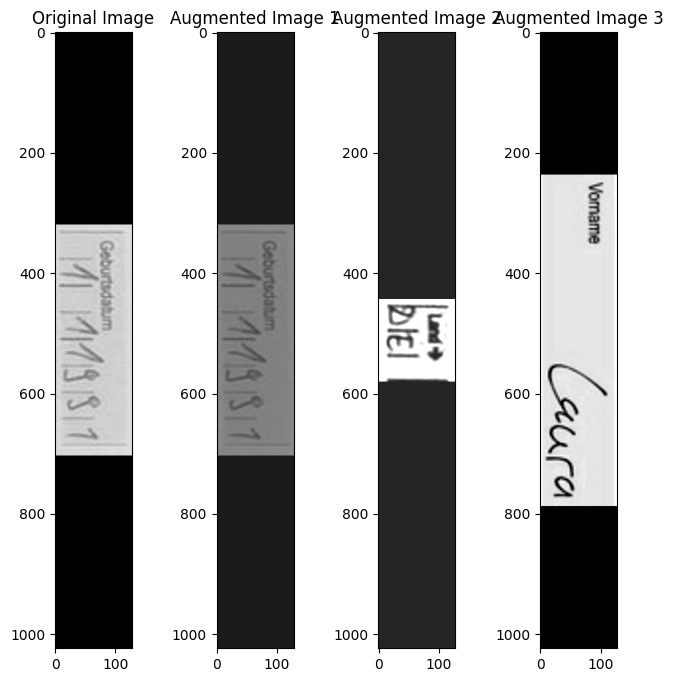

In [11]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.RandomBrightness(0.5,value_range=(0, 1), seed=TF_SEED),
        tf.keras.layers.RandomContrast(0.5,seed=TF_SEED)
    ]
)

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.imshow(images[0].numpy(), cmap='gray', vmin=0, vmax=1)
plt.title("Original Image")

# Apply data augmentation to the image
augmented_images = data_augmentation(images, training=True)

# Display the augmented images
for i in range(3):
    plt.subplot(1, 4, i + 2)
    plt.imshow(augmented_images[i].numpy(), cmap='gray', vmin=0, vmax=1)
    plt.title(f"Augmented Image {i+1}")
    
plt.show()

# Train Keras Model

In [12]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [25]:
def train_model(model):
    #model_load_weights_if_exists(model)
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    # checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)

    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-9, verbose=10)
    # history = model.fit(train_ds, validation_data=val_ds, epochs=500, callbacks=[reduce_lr, early_stopping])    
    history = model.fit(train_ds, validation_data=val_ds, epochs=500)   
    return prediction_model, history

# Transfer Model

In [14]:
from keras.models import load_model
def load_model_and_weights():
    weights_keras_string = "_weights.keras"
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    model_weight_path = "./handwriting/models/model9v3_xl/model9v3_xl_weights.keras"
    model_path = "./handwriting/models/model9v3_xl"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [16]:
model = load_model_and_weights()
char = len(tokenizer.char_to_num.get_vocabulary())
model = testing_models.load_and_finetune_model2(model, IMAGE_WIDTH, IMAGE_HEIGHT, char, LEARNING_RATE)
model.summary()

./handwriting/models/model9v3_xl
Loading pre-trained model and weights...
Model and weights loaded successfully.
Model: "finetuned_handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 1024, 128,   0           []                               
                                1)]                                                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 1024, 128, 4  480         ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 Conv2 (Conv2D)                 (None, 1024, 128, 9  

In [ ]:
start_time = time.time()

prediction_model, history = train_model(model)

total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/500
15/15 [==============================] - 3s 198ms/step - loss: 13.0624 - val_loss: 16.5302
Epoch 2/500
15/15 [==============================] - 3s 193ms/step - loss: 13.0254 - val_loss: 16.5372
Epoch 3/500
15/15 [==============================] - 3s 193ms/step - loss: 12.9818 - val_loss: 16.5415
Epoch 4/500
15/15 [==============================] - 3s 189ms/step - loss: 12.9934 - val_loss: 16.5468
Epoch 5/500
15/15 [==============================] - 3s 197ms/step - loss: 12.9420 - val_loss: 16.5535
Epoch 6/500
15/15 [==============================] - 3s 195ms/step - loss: 12.9888 - val_loss: 16.5505
Epoch 7/500
15/15 [==============================] - 3s 194ms/step - loss: 13.0783 - val_loss: 16.5489
Epoch 8/500
15/15 [==============================] - 3s 192ms/step - loss: 12.8703 - val_loss: 16.5531
Epoch 9/500
15/15 [==============================] - 3s 191ms/step - loss: 13.1121 - val_loss: 16.5571
Epoch 10/500
15/15 [==============================] - 3s 194ms/step - los

# Plot helper functions

In [18]:
def plot_history(history, name, dir_path, save_fig):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [19]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [20]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_transfer_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [21]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

# Model Testing

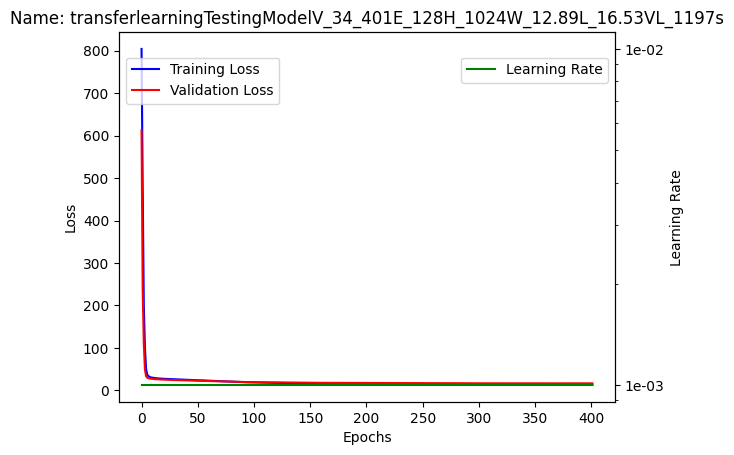

2/2 [==============================] - 4s 1s/step


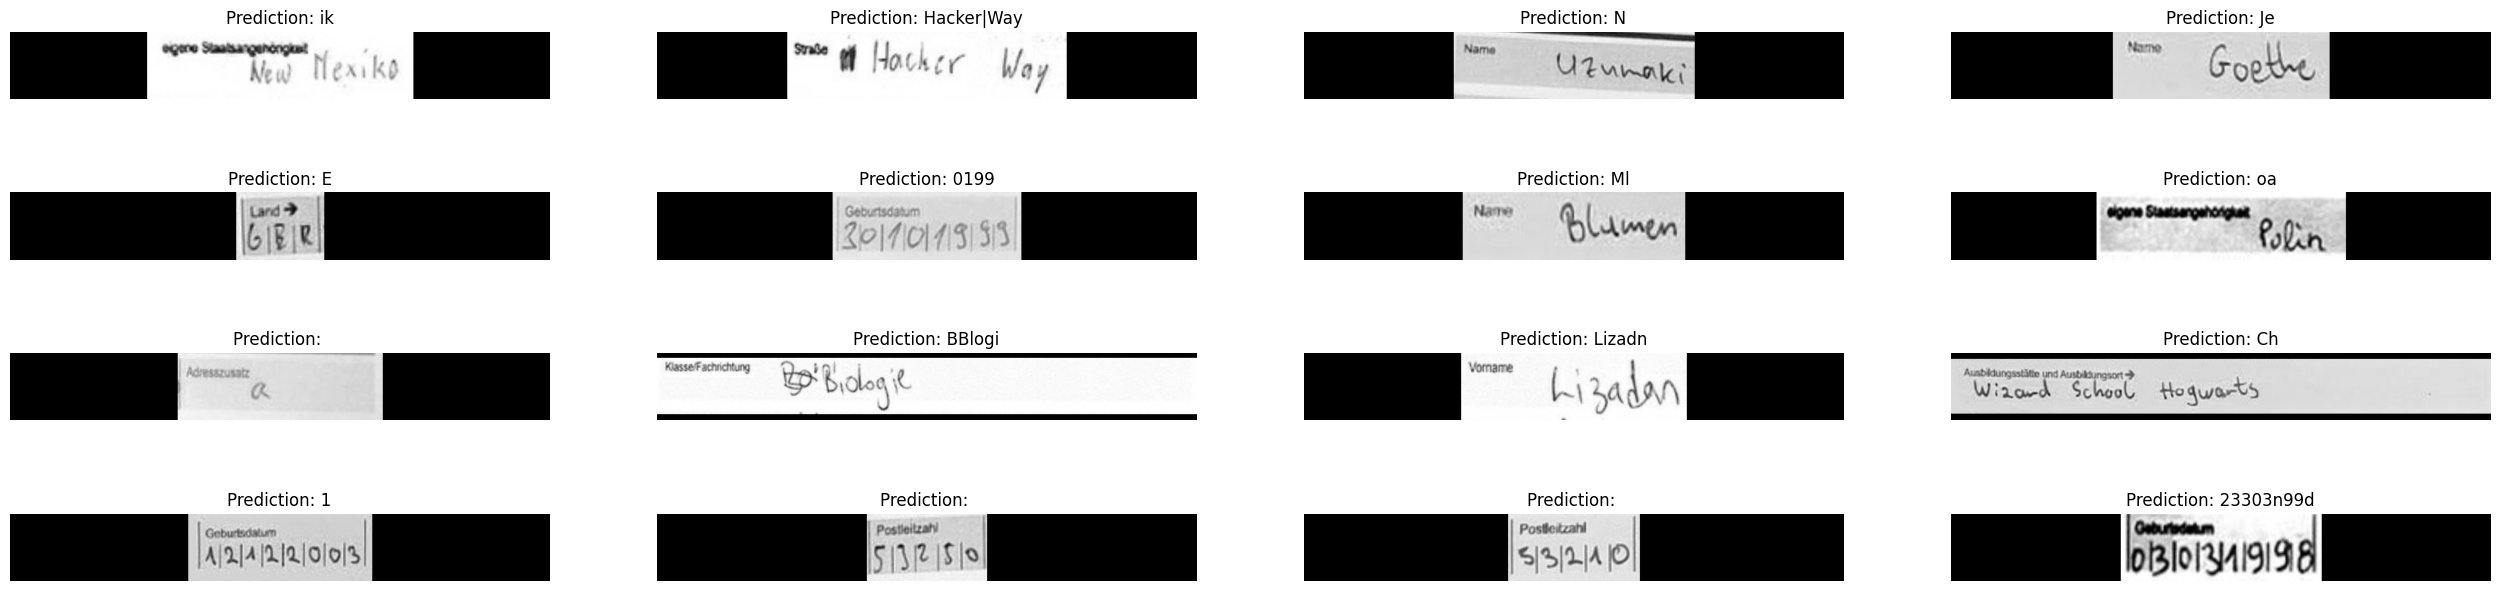

In [22]:
def create_new_plot_name(model_name, names, format):
    import re
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    return format.replace(model_name,new_model_name)
        
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [23]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

INFO:tensorflow:Assets written to: C:\Users\timBo\Desktop\Python Projects\SmartApp-Project\models\transferlearningTestingModel\assets


INFO:tensorflow:Assets written to: C:\Users\timBo\Desktop\Python Projects\SmartApp-Project\models\transferlearningTestingModel\assets
